### Задание 2

Подведите результаты эксперимента в экселе по следующим данным: ab_stats.csv - Google Диск:

Стат значимо ли отличается ARPPU в двух группах? Какие рекомендации дадите менеджеру?

In [95]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import kstest

In [96]:
data = pd.read_csv('ab_stats.csv')
data.head(20)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [97]:
# Общая информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [98]:
# Продемонстрировать размерность датафрейма
data.shape

(23652, 5)

In [99]:
# Статистическая сводка
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [100]:
# Проверяем на наличие пропущенных значений и суммируем пропуски
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [101]:
# Группируем данные по типу выборки, агрегируем по revenue
grouped_data = data.groupby(['ab_group'], as_index=False).agg({'revenue': 'sum'})
grouped_data.head()

,ab_group,revenue
0,A,4786.807972
1,B,2892.735789


In [102]:
# строки где выручка больше 0
new_data = data[data['revenue'] > 0]
new_data

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


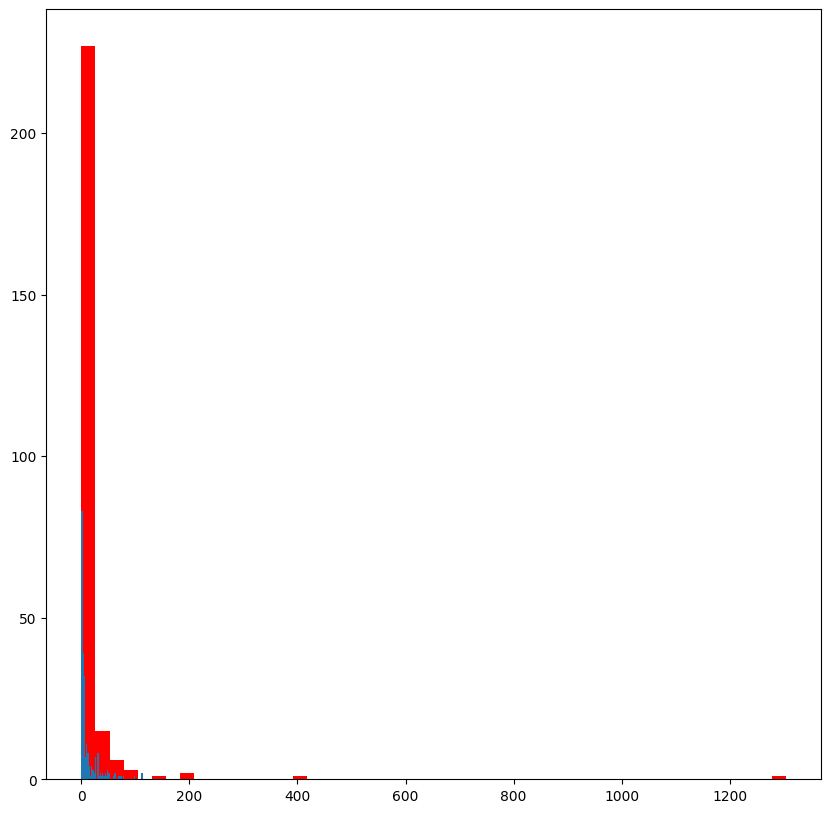

In [103]:
# График распределения
plt.figure(figsize=(10, 10))
A_group = new_data['revenue'][data['ab_group']=='A']
B_group = new_data['revenue'][data['ab_group']=='B']

plt.hist(A_group, color='r', bins=50)
plt.hist(B_group, bins=50)

plt.show()

In [104]:
ttest_ind(A_group, B_group, equal_var = False)

TtestResult(statistic=1.1295123189663723, pvalue=0.2596444677902523, df=281.17051291452685)

p-value > 0.05

Значимых изменений нет

In [105]:
# Проверка на нормальность с помощью теста Колмогорова-Смирнова
print(kstest(A_group, 'norm'))
print(kstest(B_group, 'norm'))

KstestResult(statistic=0.8312038740127529, pvalue=5.535202851866459e-197, statistic_location=1.9727, statistic_sign=-1)
KstestResult(statistic=0.8635160979681316, pvalue=1.877582850318663e-202, statistic_location=1.953625, statistic_sign=-1)


p-value < 0.05

Принимаем альтернативную гипотезу о том, что данные распределены ненормально

In [106]:
# Расчет стат значимости Манна Уитни
from scipy.stats import mannwhitneyu
mannwhitneyu(A_group, B_group)

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

p-value > 0.05

Принимаем нулевую гипотезу о том, что значимых изменений нет

In [107]:
# Функция бутстрепа
from scipy.stats import norm

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    # значения квантилей
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

100%|██████████| 10000/10000 [00:03<00:00, 2935.95it/s]


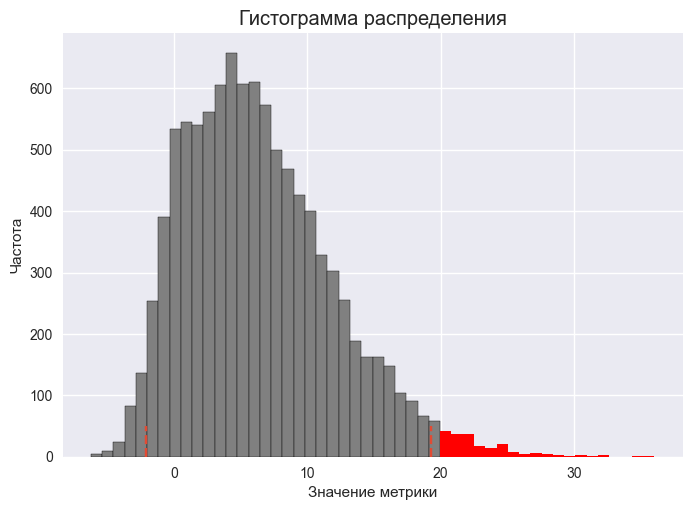

p_value 0.25232465475566956


In [109]:
plt.style.use('seaborn-v0_8')
pd.options.display.float_format = '{:,.2f}'.format
# если 0 включен в доверительный интервал между группами нет разницы
# в результате хранится разница двух распределений, ДИ и pvalue
booted_data = get_bootstrap(A_group,
                            B_group,
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

p-value > 0.05

Оставить контрольный вариант без изменений